<a href="https://colab.research.google.com/github/pr-shukla/Pursuit-Evasion-Reinforcement-Learning/blob/main/multi_pursuer_evader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
from tensorflow.keras.models import load_model

In [7]:
#Dimension of State Space for single agent
dim_agent_state = 3

#hidden_nodes = 3

#Time Difference Between 2 Steps
dt = 0.4

#Number of Episodes
num_episodes = 1000

#Number of Steps

num_steps = 400

#buffer_range = 60

#Minimum turing radius of Pursuer
rho = 0.3

#velocity of pursuer
v = 1.0


#Velocity of Evader during training
ve = 0.5

#angle between initial velocity and reference
te = 3*np.pi/4

num_agents = 2

#Dimension of State Space
dim_state = dim_agent_state*num_agents

In [8]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=0.4, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [9]:
class Buffer:
    def __init__(self, buffer_capacity=10000, batch_size=64):

        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, dim_state))
        self.action_buffer = np.zeros((self.buffer_capacity, num_agents))
        self.reward_buffer = np.zeros((self.buffer_capacity, num_agents))
        self.next_state_buffer = np.zeros((self.buffer_capacity, dim_state))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self, ac_models, cr_models, target_ac, target_cr):
      for i in range(num_agents):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.

        target_actions = np.zeros((self.batch_size, num_agents))
        for j in range(num_agents):
          target_actions[:,j] = tf.reshape(
              target_ac[j](next_state_batch[:,3*j:3*(j+1)]), [self.batch_size]
              )

        target_action_batch1 = target_actions[:,0]
        target_action_batch2 = target_actions[:,1]
        action_batch1 = action_batch[:,0]
        action_batch2 = action_batch[:,1]
    
        with tf.GradientTape() as tape:
            y = reward_batch[:,i] + gamma * target_cr[i]([
                                                          next_state_batch, target_action_batch1, target_action_batch2
                                                          ])
            critic_value = cr_models[i]([
                                         state_batch, action_batch1, action_batch2
                                         ])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, cr_models[i].trainable_variables)
        #print(np.shape(critic_grad[0]),np.shape(critic_grad[1]))
        critic_optimizer.apply_gradients(
            zip(critic_grad, cr_models[i].trainable_variables)
        )

        actions = np.zeros((self.batch_size, num_agents))
        for j in range(num_agents):
          a = ac_models[j](state_batch[:,3*j:3*(j+1)])
          actions[:,j] = tf.reshape(a, [self.batch_size])

        #actions = tf.Variable(actions)

        '''
        with tf.GradientTape() as tape:
          critic_value = cr_models[i]([state_batch, actions])
        critic_grad_ac = tape.gradient(critic_value, actions)
        
        with tf.GradientTape() as tape:
          action = ac_models[i](state_batch)
        ac_gradient = tape.gradient(action, ac_models[i].trainable_variables)
        print(np.shape(ac_gradient), len(ac_gradient), np.shape(critic_grad_ac), len(critic_grad_ac))

        for j in range(len(critic_grad_ac)):
          critic_grad_ac[j] += critic_grad_ac[j]*float(ac_gradient[j]) 
        critic_grad_ac /= self.batch_size
        
        actor_optimizer.apply_gradients(
            zip(ac_gradient, ac_models[i].trainable_variables)
        )
        print(11,np.shape(critic_grad_ac))
        '''
        


        #print(np.shape(ac_gradient[0]),np.shape(ac_gradient[1]))

        if i == 0:
          with tf.GradientTape() as tape:
              #print(actions[:,i].shape, tf.squeeze(ac_models[i](state_batch)).shape)
              action_ = ac_models[i](state_batch[:,3*i:3*(i+1)])
              #actions[:,i] = tf.squeeze(action_)
              #actions[:,1] = tf.reshape(ac_models[1](state_batch), [self.batch_size])
              #actions = ac_models[i](state_batch)
              critic_value = cr_models[i]([state_batch, action_, actions[:,1]])
              # Used `-value` as we want to maximize the value given
              # by the critic for our actions
              actor_loss = -tf.math.reduce_mean(critic_value)
        else:
          with tf.GradientTape() as tape:
              #print(actions[:,i].shape, tf.squeeze(ac_models[i](state_batch)).shape)
              action_ = ac_models[i](state_batch[:,3*i:3*(i+1)])
              #actions[:,i] = tf.squeeze(action_)
              #actions[:,1] = tf.reshape(ac_models[1](state_batch), [self.batch_size])
              #actions = ac_models[i](state_batch)
              critic_value = cr_models[i]([state_batch, actions[:,0], action_])
              # Used `-value` as we want to maximize the value given
              # by the critic for our actions
              actor_loss = -tf.math.reduce_mean(critic_value)
          
        #print(ac_models[i].trainable_variables, actor_loss)
        actor_grad = tape.gradient(actor_loss, ac_models[i].trainable_variables)
        #print(actor_grad)
        actor_optimizer.apply_gradients(
            zip(actor_grad, ac_models[i].trainable_variables)
        )
        


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau, ac_models, cr_models, target_ac, target_cr):
  for i in range(num_agents):
    new_weights = []
    target_variables = target_cr[i].weights
    for j, variable in enumerate(cr_models[i].weights):
        new_weights.append(variable * tau + target_variables[j] * (1 - tau))

    target_cr[i].set_weights(new_weights)

    new_weights = []
    target_variables = target_ac[i].weights
    for j, variable in enumerate(ac_models[i].weights):
        new_weights.append(variable * tau + target_variables[j] * (1 - tau))

    target_ac[i].set_weights(new_weights)

In [5]:
'''
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.00003, maxval=0.00003)

    inputs = layers.Input(shape=(3,))
    out = layers.Dense(512, activation="selu", kernel_initializer='lecun_normal')(inputs)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    
    out = layers.Dense(512, activation="selu", kernel_initializer='lecun_normal')(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    
    
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs 
    model = tf.keras.Model(inputs, outputs)
    return model
'''

def get_actor():
    last_init = tf.random_uniform_initializer(minval=-0.0003, maxval=0.0003)
    base_model = load_model('actor_model.h5')#(include_top=False)
    #base_model.summary()
    #out = layers.Dense(256, activation="selu", kernel_initializer='lecun_normal')(base_model.layers[6].output)
    #out = layers.Dropout(rate=0.5)(out)
    #out = layers.BatchNormalization()(out)

    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(base_model.layers[6].output)
    outputs = outputs

    model = tf.keras.Model(inputs = base_model.input, outputs = outputs)

    #i = 0

    for layer in base_model.layers:
        #i += 1
        #print(i)

        layer.trainable = False

    return model




'''
def get_critic():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    # State as input
    state_input = layers.Input(shape=(dim_state))
    state_out = layers.Dense(16, activation="selu", kernel_initializer="lecun_normal")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(state_out)
    state_out = layers.BatchNormalization()(state_out)

    # Action as input
    action_input1 = layers.Input(shape=(1))
    action_out1 = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(action_input1)
    action_out1 = layers.BatchNormalization()(action_out1)

    # Action as input
    action_input2 = layers.Input(shape=(1))
    action_out2 = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(action_input2)
    action_out2 = layers.BatchNormalization()(action_out2)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out1, action_out2])

    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(concat)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input1, action_input2], outputs)

    return model
    '''
def get_critic():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    # State as input
    state_input = layers.Input(shape=(dim_state))
    state_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(64, activation="selu", kernel_initializer="lecun_normal")(state_out)
    state_out = layers.BatchNormalization()(state_out)

    # Action as input
    action_input1 = layers.Input(shape=(1))
    action_input2 = layers.Input(shape=(1))
    action_input = layers.Concatenate()([action_input1, action_input2])
    action_out = layers.Dense(64, activation="selu", kernel_initializer="lecun_normal")(action_input)
    action_out = layers.BatchNormalization()(action_out)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(1024, activation="selu", kernel_initializer="lecun_normal")(concat)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(1024, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    
    '''
    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    '''
    outputs = layers.Dense(1)(out)
    '''
    action_input1 = layers.Input(shape=(1))
    action_out1 = layers.Dense(16, activation="selu", kernel_initializer="lecun_normal")(action_input1)
    action_out1 = layers.BatchNormalization()(action_out1)

    # Action as input
    action_input2 = layers.Input(shape=(1))
    action_out2 = layers.Dense(16, activation="selu", kernel_initializer="lecun_normal")(action_input2)
    action_out2 = layers.BatchNormalization()(action_out2)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out1, action_out2])

    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(concat)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    '''

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input1, action_input2], outputs)

    return model

In [10]:
def policy(state, noise_object, model):
    
    sampled_actions = tf.squeeze(model(state))
    noise = noise_object()

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)

    return [np.squeeze(legal_action)]



In [11]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

ac_models = []
cr_models = []
target_ac = []
target_cr = []

for i in range(num_agents):
  ac_models.append(get_actor()) 
  cr_models.append(get_critic())

  target_ac.append(get_actor())
  target_cr.append(get_critic())

  # Making the weights equal initially
  target_ac[i].set_weights(ac_models[i].get_weights())
  target_cr[i].set_weights(cr_models[i].get_weights())


# Learning rate for actor-critic models
critic_lr = 1e-6
actor_lr = 5e-7


critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 50
# Discount factor for future rewards
gamma = 0.95
# Used to update target networks
tau = 0.005

buffer = Buffer(20000, 128)

In [12]:
#Function for generating sigmoid output of Input Function
def sigmoid(x):
    val = 1/(1+np.exp(-x))
    return val

#Calculating Distance between Pursuer and Evader
def L(rx1, ry1, rx2, ry2):
    d = np.sqrt((rx2-rx1)**2 + (ry2-ry1)**2)
    return d
'''
def L(state):
    L = np.sqrt((state[4] - state[0])**2 + (state[5]-state[1])**2)
    return L
'''

'''
#Magnitude of Velocity Calculator
def V(state):
    v = np.sqrt(state[2]**2+state[3]**2)
    return v
'''

#Calculating angle between velocity and reference axis
def thetap(state):
    v = 1.0
    angle = math.acos(state[2]/v)*((state[3]+0.001)/abs(state[3]+0.001))-np.pi*((state[3]+0.0001)/(abs(state[3])+0.0001)-1)
    return angle

def alph(state):
    l = L(state)
    angle = math.acos((state[4]-state[0])/l)*(state[5]-state[1]+0.0001)/abs(state[5]-state[1]+0.0001)-(np.pi)*(((state[5]-state[1]+0.0001)/abs(0.0001+state[5]-state[1]))-1)
    return angle

#Reward Calculator
def reward(state):
  rewards = []
  for i in range(num_agents):
    '''
    ag_state = []
    for j in state[i*4:(i+1)*4]:
      ag_state.append(j)
    for j in ev_state:
      ag_state.append(j)
    '''

    r1 = 10*np.exp(-3*state[0+i*3])
    r2 = 10*np.exp(-1*state[1+i*3])
    r3 = 5*np.arctan(1*state[2+i*3])
    r4 = 5*np.exp(-3*state[2+i*3])
    r5 = 10*np.exp(-1*state[0+i*3]*state[2+i*3])
    r =  r1 + r4 #+ r2  #+ r3 
    
    rewards.append(r)

  return rewards

#Calculator of Angle between velocity and line joining Evader and Pursuer
def phi(rx1, ry1, vx1, vy1, rx2, ry2):
    d = L(rx1, ry1, rx2, ry2)
    rx2_rx1 = rx2 - rx1
    ry2_ry1 = ry2 - ry1
    angle = math.acos(round((rx2_rx1*vx1+ ry2_ry1*vy1)/d, 4))
    return angle
'''
def phi(state):
    x_pursuer = state[0]
    y_pursuer = state[1]
    x_evader = state[4]
    y_evader = state[5]
    
    x_velocity_pursuer = state[2]
    y_velocity_pursuer = state[3]
    
    x_evader_pursuer = x_evader - x_pursuer
    y_evader_pursuer = y_evader - y_pursuer
    
    d = L(state)
    
    angle = math.acos(round((x_evader_pursuer*x_velocity_pursuer+ y_evader_pursuer*y_velocity_pursuer)/d, 4))
    
    return angle
'''
'''
# Transition from Current State to New State
def transition(pursuer_state, state, actions, ev_state):

    p_state = []
    complete_state = []
    
    for i in range(num_agents):
      
      ag_state = []
      for j in state[i*4:(i+1)*4]:
        ag_state.append(j)
      for j in ev_state:
        ag_state.append(j)

      #angle between velocity and reference axis
      theta_velocity_p = thetap(ag_state)

      old_phi = phi(ag_state)

      #Change in x and y position of Pursuer
      del_xp = ag_state[2]*dt
      del_yp = ag_state[3]*dt
      
      del_xe = ve*np.cos(te)*dt
      del_ye = ve*np.sin(te)*dt

      #Change in Angle between velocity and reference axis
      del_theta_velocity_p = (v/rho)*actions[i]*dt
      theta_velocity_p = theta_velocity_p + del_theta_velocity_p

      #New x and y position of Pursuer
      ag_state[0] = ag_state[0] + del_xp
      ag_state[1] = ag_state[1] + del_yp

      ag_state[4] = ag_state[4] + del_xe
      ag_state[5] = ag_state[5] + del_ye
    
      #New x and y velocity of Pursuer
      ag_state[2] = 1.0*np.cos(theta_velocity_p)
      ag_state[3] = 1.0*np.sin(theta_velocity_p)
    
      new_phi = phi(ag_state)

      pur_state = [0,0,0]
    
      #New phi and phi(dot)
      pur_state[1] = phi(ag_state)/np.pi
      pur_state[0] = L(ag_state)/30.0
      pur_state[2] = (new_phi-old_phi)/(dt)
      
      for j in pur_state:
        p_state.append(j)
      for j in ag_state[:4]:
        complete_state.append(j)
    ev_state[0] = ag_state[4]
    ev_state[1] = ag_state[5]

    return p_state, complete_state, ev_state
'''

'\n# Transition from Current State to New State\ndef transition(pursuer_state, state, actions, ev_state):\n\n    p_state = []\n    complete_state = []\n    \n    for i in range(num_agents):\n      \n      ag_state = []\n      for j in state[i*4:(i+1)*4]:\n        ag_state.append(j)\n      for j in ev_state:\n        ag_state.append(j)\n\n      #angle between velocity and reference axis\n      theta_velocity_p = thetap(ag_state)\n\n      old_phi = phi(ag_state)\n\n      #Change in x and y position of Pursuer\n      del_xp = ag_state[2]*dt\n      del_yp = ag_state[3]*dt\n      \n      del_xe = ve*np.cos(te)*dt\n      del_ye = ve*np.sin(te)*dt\n\n      #Change in Angle between velocity and reference axis\n      del_theta_velocity_p = (v/rho)*actions[i]*dt\n      theta_velocity_p = theta_velocity_p + del_theta_velocity_p\n\n      #New x and y position of Pursuer\n      ag_state[0] = ag_state[0] + del_xp\n      ag_state[1] = ag_state[1] + del_yp\n\n      ag_state[4] = ag_state[4] + del_xe\n

In [13]:
import random
class environment:
  def __init__(self):
    self.p1_rx = random.uniform(0.0, 10.0)
    self.p1_ry = random.uniform(0.0, 10.0)
    self.p2_rx = random.uniform(0.0, 10.0)
    self.p2_ry = random.uniform(0.0, 10.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.p2_vx = 1.0
    self.p2_vy = 0.0
    self.e_rx = 5.0
    self.e_ry = 5.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                   self.p1_ry]
    state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                   self.p1_ry]
    return state_p1_e, state_p2_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    theta_v_p1 = thetap(state_p1_e)
    theta_v_p2 = thetap(state_p2_e)

    

    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_p2 = self.p2_vx * dt
    del_ry_p2 = self.p2_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*actions[0]*dt
    del_theta_v_p2 = (1.0/rho)*actions[1]*dt

    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_p2 = theta_v_p2 + del_theta_v_p2

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.p2_rx = self.p2_rx + del_rx_p2
    self.p2_ry = self.p2_ry + del_ry_p2
    self.p2_vx = 1.0 * np.cos(theta_v_p2)
    self.p2_vy = 1.0 * np.sin(theta_v_p2)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    return state_p1_e, state_p2_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e, state_p2_e = self.state_step(actions)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)

    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]

    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    
    return obs

Episode * 1 * Avg Reward is ==> 4206.10995780664 : Ag1 Reward ==> 2238.604225973394 : Ag2 Reward ==> 1967.505731833244 


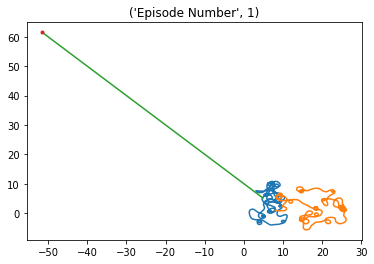

KeyboardInterrupt: ignored

In [14]:

ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

ag1_reward_list = []
ag2_reward_list = []

# Takes about 20 min to train
for ep in range(num_episodes):

    env = environment()
    prev_state = env.initial_obs()

    '''
    sys_state = [0.0,0.0,1.0,0.0]
    ev_state = [5.0,5.0]

    ag_state = []

    for i in sys_state:
      ag_state.append(i)
    for i in ev_state:
      ag_state.append(i)
    
    prev_state = [L(ag_state)/30.0, phi(ag_state)/np.pi, 0.0]

    for i in range(1,num_agents):
      sys_state.append(sys_state[0])
      sys_state.append(sys_state[1]+i)
      sys_state.append(sys_state[2])
      sys_state.append(sys_state[3])

      ag_state = []

      for j in sys_state[i*4:]:
        ag_state.append(j)
      for j in ev_state:
        ag_state.append(j)

      prev_state.append(L(ag_state)/30.0)
      prev_state.append(phi(ag_state)/np.pi)
      prev_state.append(0.0)
    
    prev_state = np.array(prev_state)
    '''
    episodic_reward = 0
    ag1_reward = 0
    ag2_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []

    
    #while True:
    for i in range(num_steps):
        
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        actions = []
        for j, model in enumerate(ac_models):
          action = policy(tf_prev_state[:,3*j:3*(j+1)], ou_noise, model)
          actions.append(float(action[0]))

        # Recieve state and reward from environment.
        #new_state, sys_state, ev_state = transition(prev_state, sys_state, actions, ev_state)
        new_state = env.step(actions)
        rewards = reward(new_state)

        buffer.record((prev_state, actions, rewards, new_state))
        
        episodic_reward += sum(rewards)
        ag1_reward += rewards[0]
        ag2_reward += rewards[1]

        buffer.learn(ac_models, cr_models, target_ac, target_cr)
        update_target(tau, ac_models, cr_models, target_ac, target_cr)

        prev_state = new_state
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)
        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)
        
        xce.append(env.e_rx)
        yce.append(env.e_ry)
        
    xc1 = [env.e_rx]
    yc1 = [env.e_ry]

    ep_reward_list.append(episodic_reward)
    ag1_reward_list.append(ag1_reward)
    ag2_reward_list.append(ag2_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {} : Ag1 Reward ==> {} : Ag2 Reward ==> {} ".format(ep+1, avg_reward, ag1_reward, ag2_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xp1,yp1)
    plt.plot(xp2,yp2)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    title = 'Episode Number', ep+1
    plt.title(title)
    plt.show()

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

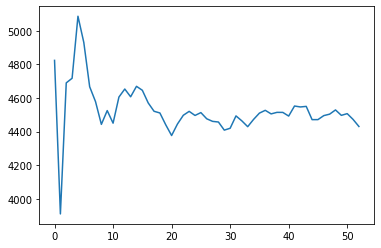

In [ ]:
plt.plot(avg_reward_list[:])
plt.show()

Episode * 1 * Avg Reward is ==> 5190.8332063708185 : Ag1 Reward ==> 2719.9705285545065 : Ag2 Reward ==> 2470.862677816314 


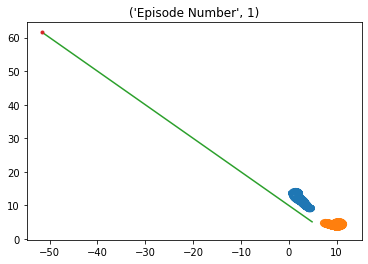

In [ ]:
ve = 0.5
dt = 0.4
rho = 0.3
def policy(state, noise_object, model):
    
    sampled_actions = tf.squeeze(model(state))
    noise = noise_object()

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + 0

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)

    return [np.squeeze(legal_action)]



ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

ag1_reward_list = []
ag2_reward_list = []

# Takes about 20 min to train
for ep in range(1):

    env = environment()
    prev_state = env.initial_obs()

    '''
    sys_state = [0.0,0.0,1.0,0.0]
    ev_state = [5.0,5.0]

    ag_state = []

    for i in sys_state:
      ag_state.append(i)
    for i in ev_state:
      ag_state.append(i)
    
    prev_state = [L(ag_state)/30.0, phi(ag_state)/np.pi, 0.0]

    for i in range(1,num_agents):
      sys_state.append(sys_state[0])
      sys_state.append(sys_state[1]+i)
      sys_state.append(sys_state[2])
      sys_state.append(sys_state[3])

      ag_state = []

      for j in sys_state[i*4:]:
        ag_state.append(j)
      for j in ev_state:
        ag_state.append(j)

      prev_state.append(L(ag_state)/30.0)
      prev_state.append(phi(ag_state)/np.pi)
      prev_state.append(0.0)
    
    prev_state = np.array(prev_state)
    '''
    episodic_reward = 0
    ag1_reward = 0
    ag2_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []

    
    #while True:
    for i in range(num_steps):
        
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        actions = []
        for j, model in enumerate(ac_models):
          action = policy(tf_prev_state[:,3*j:3*(j+1)], ou_noise, model)
          actions.append(float(action[0]))

        # Recieve state and reward from environment.
        #new_state, sys_state, ev_state = transition(prev_state, sys_state, actions, ev_state)
        new_state = env.step(actions)
        rewards = reward(new_state)

        #buffer.record((prev_state, actions, rewards, new_state))
        
        episodic_reward += sum(rewards)
        ag1_reward += rewards[0]
        ag2_reward += rewards[1]

        #buffer.learn(ac_models, cr_models, target_ac, target_cr)
        #update_target(tau, ac_models, cr_models, target_ac, target_cr)

        prev_state = new_state
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)
        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)
        
        xce.append(env.e_rx)
        yce.append(env.e_ry)
        
    xc1 = [env.e_rx]
    yc1 = [env.e_ry]

    ep_reward_list.append(episodic_reward)
    ag1_reward_list.append(ag1_reward)
    ag2_reward_list.append(ag2_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {} : Ag1 Reward ==> {} : Ag2 Reward ==> {} ".format(ep+1, avg_reward, ag1_reward, ag2_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xp1,yp1)
    plt.plot(xp2,yp2)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    title = 'Episode Number', ep+1
    plt.title(title)
    plt.show()

# Plotting graph
# Episodes versus Avg. Rewards
